In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import multiprocessing as mp
import tqdm
from functools import partial

from specsens import util
from specsens import util_sim
from specsens import WirelessMicrophone
from specsens import WhiteGaussianNoise
from specsens import Stft
from specsens import WidebandEnergyDetector
from specsens import noise_est as noise_esti


def generation(f_sample, length_sec, itrs, noise_power, signal_power,
               noise_uncert, window, fft_len, sigs, num_bands,
               band_noise_est, cov_size, seeds):

    # create new signal objects
    wm = WirelessMicrophone(f_sample=f_sample, t_sec=length_sec, seed=seeds[0])
    wgn = WhiteGaussianNoise(f_sample=f_sample,
                             t_sec=length_sec,
                             seed=seeds[1])

    # local rng
    rng = np.random.default_rng(seeds[2])

    # calculate noise power with uncertainty
    gen_noise_power = rng.normal(loc=noise_power, scale=noise_uncert)

    # list of noise estimation errors
    errs_time = np.array([])
    errs_band = np.array([])
    errs_eig_avg = np.array([])
    errs_eig_hist = np.array([])
    errs_eig_kde = np.array([])
    errs_eig_mle = np.array([])

    # 'inner' interations loop
    for _ in range(itrs):

        sig = wm.soft(f_center=0., power=signal_power, dB=True)
        for i in range(-int(sigs*100000), 0, 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        for i in range(50000, int(sigs*100000+50000), 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        
        # generate noise
        noise = wgn.signal(power=gen_noise_power, dB=True)

        # create acutal signal
        both = sig + noise

        # time noise estimation
        est_time = util.dB_power(np.mean(np.abs(noise)**2.))

        # create a Short Time Fourier Transform object
        sft = Stft(n=fft_len, window=window)
        # use the stft to transform the signal into the frequency domain
        f, psd = sft.stft(both, f_sample, normalized=False, dB=False)
#         f, psd = sft.stft(noise, f_sample, normalized=False, dB=False)
        # create a Wideband Energy Detector object
        fed = WidebandEnergyDetector(num_bands=num_bands,
                                     f_sample=f_sample,
                                     fft_len=fft_len,
                                     freqs=f)
        # compute energy for all bands
        bands = fed.detect(psd)
        # in band noise estimation
        est_band = util.dB_power(bands[band_noise_est] / (fft_len / num_bands))

        # eigenvalue noise estimation
        est_eig_avg, est_eig_hist, est_eig_kde, est_eig_mle = noise_esti.estimate(
            both, int(f_sample * length_sec), l=cov_size)

        # calculate errors
        err_time = util.dB_rel_err(gen_noise_power, est_time)
        err_band = util.dB_rel_err(gen_noise_power, est_band)
        err_eig_avg = util.dB_rel_err(gen_noise_power, est_eig_avg)
        err_eig_hist = util.dB_rel_err(gen_noise_power, est_eig_hist)
        err_eig_kde = util.dB_rel_err(gen_noise_power, est_eig_kde)
        err_eig_mle = util.dB_rel_err(gen_noise_power, est_eig_mle)

        # append to errors list
        errs_time = np.append(errs_time, err_time)
        errs_band = np.append(errs_band, err_band)
        errs_eig_avg = np.append(errs_eig_avg, err_eig_avg)
        errs_eig_hist = np.append(errs_eig_hist, err_eig_hist)
        errs_eig_kde = np.append(errs_eig_kde, err_eig_kde)
        errs_eig_mle = np.append(errs_eig_mle, err_eig_mle)

    # calculate average error and return
    return np.mean(errs_time), np.mean(errs_band), np.mean(
        errs_eig_avg), np.mean(errs_eig_hist), np.mean(errs_eig_kde), np.mean(
            errs_eig_mle)


def estimation_comparison_sim(
        gens=50,  # generations, number of environments
        itrs=300,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=0.,  # in dB
        sigs=0,  # signals
        noise_power=0.,  # in dB
        length_sec=None,  # length of each section in seconds
        num_samples=None,  # number of samples
        noise_uncert=0.0,  # standard deviation of the noise normal distribution
        seed=None,  # random seed used for rng
        num_procs=None,  # number of processes to run in parallel
        window='box',  # window used with fft
        fft_len=1024,  # samples used for fft
        num_bands=1,  # total number of bands
        band_noise_est=None,  # band to use for noise estimation
        cov_size=50):

    # set number of processes used
    if num_procs is None:
        num_procs = mp.cpu_count()
    assert num_procs > 0, 'num_procs must be greater than 0'
    assert num_procs <= gens, 'num_procs must be less or equal to gens'

    # check and calculate length (in seconds and number of samples)
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Num sigs:       %d' % (sigs))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert:   %.2f dB' % (noise_uncert))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f s' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('FFT length:     %d' % (fft_len))
    print('Num. of bands:  %d' % (num_bands))
    print('Band noise est: %d' % (band_noise_est))

    print('---- Running simulation ----')
    print('Using %d processes on %d cores' % (num_procs, mp.cpu_count()))

    # generate child seeds for wm and wgn
    seed_seq = np.random.SeedSequence(seed)
    seeds = list(
        zip(seed_seq.spawn(gens), seed_seq.spawn(gens), seed_seq.spawn(gens)))

    # prepare parallel execution
    p = mp.Pool(processes=num_procs)
    f = partial(generation, f_sample, length_sec, itrs, noise_power,
                signal_power, noise_uncert, window, fft_len, sigs,
                num_bands, band_noise_est, cov_size)

    # run simulation while showing progress bar
    res = list(tqdm.tqdm(p.imap(f, seeds), total=gens))

    # cleanup parallel execution
    p.close()
    p.join()

    # 'unwrap' res tuples
    errs_time = [r[0] for r in res]
    errs_band = [r[1] for r in res]
    errs_eig_avg = [r[2] for r in res]
    errs_eig_hist = [r[3] for r in res]
    errs_eig_kde = [r[4] for r in res]
    errs_eig_mle = [r[5] for r in res]

    err_time = np.mean(errs_time)
    err_band = np.mean(errs_band)
    err_eig_avg = np.mean(errs_eig_avg)
    err_eig_hist = np.mean(errs_eig_hist)
    err_eig_kde = np.mean(errs_eig_kde)
    err_eig_mle = np.mean(errs_eig_mle)

    print('---- Simulation stats ----')
    print('Err time:             %.4f dB' % (err_time))
    print('Err band:             %.4f dB' % (err_band))
    print('Err eigenval average: %.4f dB' % (err_eig_avg))
    print('Err eigenval hist:    %.4f dB' % (err_eig_hist))
    print('Err eigenval kde:     %.4f dB' % (err_eig_kde))
    print('Err eigenval mle:     %.4f dB' % (err_eig_mle))

    return err_time, err_band, err_eig_avg, err_eig_hist, err_eig_kde, err_eig_mle

gens=50
itrs=1

In [4]:
res_list_length = []
x_length = list(map(lambda x: 2**x, range(9, 20)))

for i in tqdm.tqdm(x_length):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=i/1e6,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=i,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_length.append(res)

  0%|          | 0/11 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.000512 s
Signal samples: 512
FFT length:     512
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



  9%|▉         | 1/11 [00:12<02:05, 12.50s/it]

---- Simulation stats ----
Err time:             -16.5231 dB
Err band:             -12.1741 dB
Err eigenval average: -15.1446 dB
Err eigenval hist:    -14.2440 dB
Err eigenval kde:     -13.8004 dB
Err eigenval mle:     -14.4075 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.001024 s
Signal samples: 1024
FFT length:     1024
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 18%|█▊        | 2/11 [00:25<01:52, 12.53s/it]

---- Simulation stats ----
Err time:             -17.8693 dB
Err band:             -14.2380 dB
Err eigenval average: -15.5308 dB
Err eigenval hist:    -15.7840 dB
Err eigenval kde:     -14.5843 dB
Err eigenval mle:     -16.5981 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.002048 s
Signal samples: 2048
FFT length:     2048
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 27%|██▋       | 3/11 [00:37<01:38, 12.35s/it]

---- Simulation stats ----
Err time:             -18.9842 dB
Err band:             -16.3114 dB
Err eigenval average: -17.3090 dB
Err eigenval hist:    -17.0437 dB
Err eigenval kde:     -17.3700 dB
Err eigenval mle:     -18.4594 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.004096 s
Signal samples: 4096
FFT length:     4096
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 36%|███▋      | 4/11 [00:49<01:26, 12.34s/it]

---- Simulation stats ----
Err time:             -19.6806 dB
Err band:             -17.2493 dB
Err eigenval average: -17.5362 dB
Err eigenval hist:    -19.0315 dB
Err eigenval kde:     -18.9606 dB
Err eigenval mle:     -19.9104 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 45%|████▌     | 5/11 [01:02<01:14, 12.46s/it]

---- Simulation stats ----
Err time:             -23.0043 dB
Err band:             -18.7303 dB
Err eigenval average: -20.5126 dB
Err eigenval hist:    -19.0098 dB
Err eigenval kde:     -20.9554 dB
Err eigenval mle:     -20.7336 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.016384 s
Signal samples: 16384
FFT length:     16384
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 55%|█████▍    | 6/11 [01:14<01:02, 12.41s/it]

---- Simulation stats ----
Err time:             -24.3899 dB
Err band:             -21.5583 dB
Err eigenval average: -23.3354 dB
Err eigenval hist:    -21.0505 dB
Err eigenval kde:     -21.9479 dB
Err eigenval mle:     -22.6302 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.032768 s
Signal samples: 32768
FFT length:     32768
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 64%|██████▎   | 7/11 [01:28<00:52, 13.01s/it]

---- Simulation stats ----
Err time:             -25.9787 dB
Err band:             -22.5702 dB
Err eigenval average: -24.2007 dB
Err eigenval hist:    -24.3645 dB
Err eigenval kde:     -23.9824 dB
Err eigenval mle:     -24.7435 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.065536 s
Signal samples: 65536
FFT length:     65536
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 73%|███████▎  | 8/11 [01:44<00:41, 13.70s/it]

---- Simulation stats ----
Err time:             -26.0714 dB
Err band:             -22.8484 dB
Err eigenval average: -24.2742 dB
Err eigenval hist:    -24.8003 dB
Err eigenval kde:     -27.8717 dB
Err eigenval mle:     -25.4014 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.131072 s
Signal samples: 131072
FFT length:     131072
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 82%|████████▏ | 9/11 [02:04<00:31, 15.85s/it]

---- Simulation stats ----
Err time:             -28.0304 dB
Err band:             -25.8711 dB
Err eigenval average: -26.1706 dB
Err eigenval hist:    -26.1289 dB
Err eigenval kde:     -26.2654 dB
Err eigenval mle:     -27.1921 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.262144 s
Signal samples: 262144
FFT length:     262144
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 91%|█████████ | 10/11 [02:34<00:20, 20.07s/it]

---- Simulation stats ----
Err time:             -31.2912 dB
Err band:             -26.5098 dB
Err eigenval average: -28.0988 dB
Err eigenval hist:    -26.9655 dB
Err eigenval kde:     -28.9929 dB
Err eigenval mle:     -27.9617 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.524288 s
Signal samples: 524288
FFT length:     524288
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 11/11 [03:23<00:00, 18.54s/it]

---- Simulation stats ----
Err time:             -31.9807 dB
Err band:             -26.9921 dB
Err eigenval average: -30.5252 dB
Err eigenval hist:    -28.0482 dB
Err eigenval kde:     -29.4760 dB
Err eigenval mle:     -28.0071 dB


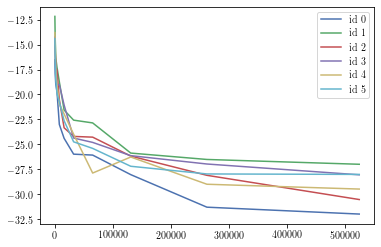

In [5]:
y = list(map(list, zip(*res_list_length)))

for i in range(6):
    plt.plot(x_length,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [6]:
res_list_sigs = []
x_sigs = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

for i in tqdm.tqdm(x_sigs):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=i,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_sigs.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:12<01:56, 12.94s/it]

---- Simulation stats ----
Err time:             -22.6730 dB
Err band:             -19.5088 dB
Err eigenval average: -22.8743 dB
Err eigenval hist:    -20.9895 dB
Err eigenval kde:     -21.1269 dB
Err eigenval mle:     -21.3764 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:25<01:41, 12.68s/it]

---- Simulation stats ----
Err time:             -22.4701 dB
Err band:             -19.5970 dB
Err eigenval average: -21.3689 dB
Err eigenval hist:    -20.0995 dB
Err eigenval kde:     -21.3103 dB
Err eigenval mle:     -21.0416 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:36<01:25, 12.26s/it]

---- Simulation stats ----
Err time:             -23.0446 dB
Err band:             -19.2601 dB
Err eigenval average: -21.3571 dB
Err eigenval hist:    -20.0995 dB
Err eigenval kde:     -21.6859 dB
Err eigenval mle:     -21.1009 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:47<01:10, 11.83s/it]

---- Simulation stats ----
Err time:             -22.1873 dB
Err band:             -19.9020 dB
Err eigenval average: -21.0764 dB
Err eigenval hist:    -18.4086 dB
Err eigenval kde:     -20.0943 dB
Err eigenval mle:     -19.7312 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [00:57<00:56, 11.30s/it]

---- Simulation stats ----
Err time:             -22.5683 dB
Err band:             -18.9741 dB
Err eigenval average: -20.3203 dB
Err eigenval hist:    -17.1304 dB
Err eigenval kde:     -18.9885 dB
Err eigenval mle:     -19.1412 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:06<00:42, 10.68s/it]

---- Simulation stats ----
Err time:             -21.7624 dB
Err band:             -7.4339 dB
Err eigenval average: -17.8670 dB
Err eigenval hist:    -17.5653 dB
Err eigenval kde:     -17.4027 dB
Err eigenval mle:     -18.0194 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:15<00:30, 10.14s/it]

---- Simulation stats ----
Err time:             -22.8925 dB
Err band:             -5.0444 dB
Err eigenval average: -18.1712 dB
Err eigenval hist:    -15.3697 dB
Err eigenval kde:     -17.6265 dB
Err eigenval mle:     -17.7886 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [01:23<00:19,  9.62s/it]

---- Simulation stats ----
Err time:             -21.7042 dB
Err band:             -4.5615 dB
Err eigenval average: -16.9098 dB
Err eigenval hist:    -14.3177 dB
Err eigenval kde:     -16.2043 dB
Err eigenval mle:     -16.3452 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [01:32<00:09,  9.39s/it]

---- Simulation stats ----
Err time:             -22.3055 dB
Err band:             -4.3205 dB
Err eigenval average: -12.1225 dB
Err eigenval hist:    -12.6771 dB
Err eigenval kde:     -10.9886 dB
Err eigenval mle:     -14.4913 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [01:42<00:00, 10.22s/it]

---- Simulation stats ----
Err time:             -22.6085 dB
Err band:             -3.5784 dB
Err eigenval average: -3.7698 dB
Err eigenval hist:    -4.0375 dB
Err eigenval kde:     -3.4543 dB
Err eigenval mle:     -4.8572 dB


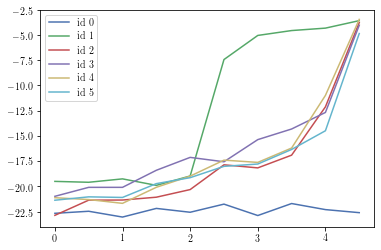

In [7]:
y = list(map(list, zip(*res_list_sigs)))

for i in range(6):
    plt.plot(x_sigs,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [8]:
res_list_snr = []
x_snr = range(-30, 20, 5)

for i in tqdm.tqdm(x_snr):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=i,  # in dB
        noise_power=0.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_snr.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -30.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -30.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:13<01:59, 13.26s/it]

---- Simulation stats ----
Err time:             -22.2711 dB
Err band:             -18.3484 dB
Err eigenval average: -20.0031 dB
Err eigenval hist:    -21.3623 dB
Err eigenval kde:     -21.6340 dB
Err eigenval mle:     -21.7970 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -25.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -25.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:26<01:45, 13.16s/it]

---- Simulation stats ----
Err time:             -22.8084 dB
Err band:             -20.1545 dB
Err eigenval average: -20.3660 dB
Err eigenval hist:    -21.3114 dB
Err eigenval kde:     -20.8987 dB
Err eigenval mle:     -20.2899 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -20.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -20.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:38<01:30, 12.92s/it]

---- Simulation stats ----
Err time:             -22.4400 dB
Err band:             -19.5322 dB
Err eigenval average: -20.2112 dB
Err eigenval hist:    -19.1260 dB
Err eigenval kde:     -20.8546 dB
Err eigenval mle:     -19.8990 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:50<01:16, 12.72s/it]

---- Simulation stats ----
Err time:             -21.5571 dB
Err band:             -20.5161 dB
Err eigenval average: -20.4329 dB
Err eigenval hist:    -20.3354 dB
Err eigenval kde:     -20.9204 dB
Err eigenval mle:     -20.4388 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [01:02<01:01, 12.32s/it]

---- Simulation stats ----
Err time:             -22.8299 dB
Err band:             -20.2143 dB
Err eigenval average: -19.8504 dB
Err eigenval hist:    -20.2984 dB
Err eigenval kde:     -21.2838 dB
Err eigenval mle:     -22.3163 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:13<00:47, 11.97s/it]

---- Simulation stats ----
Err time:             -21.6218 dB
Err band:             -18.5962 dB
Err eigenval average: -20.0193 dB
Err eigenval hist:    -19.3864 dB
Err eigenval kde:     -19.7549 dB
Err eigenval mle:     -19.9809 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   0.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            0.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:24<00:34, 11.61s/it]

---- Simulation stats ----
Err time:             -22.8794 dB
Err band:             -17.6871 dB
Err eigenval average: -20.6668 dB
Err eigenval hist:    -20.1123 dB
Err eigenval kde:     -20.4159 dB
Err eigenval mle:     -20.2078 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [01:34<00:22, 11.36s/it]

---- Simulation stats ----
Err time:             -21.6926 dB
Err band:             -18.4362 dB
Err eigenval average: -21.4879 dB
Err eigenval hist:    -18.5489 dB
Err eigenval kde:     -21.2559 dB
Err eigenval mle:     -20.0011 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [01:45<00:11, 11.17s/it]

---- Simulation stats ----
Err time:             -22.9431 dB
Err band:             -17.9797 dB
Err eigenval average: -20.5207 dB
Err eigenval hist:    -18.7210 dB
Err eigenval kde:     -19.9773 dB
Err eigenval mle:     -20.3286 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [01:55<00:00, 11.60s/it]

---- Simulation stats ----
Err time:             -21.6853 dB
Err band:             -15.9514 dB
Err eigenval average: -21.2168 dB
Err eigenval hist:    -18.6857 dB
Err eigenval kde:     -20.8443 dB
Err eigenval mle:     -19.2372 dB


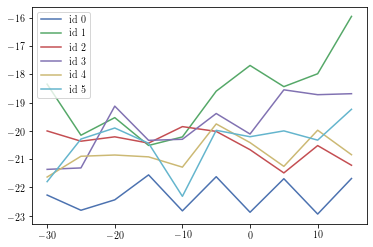

In [9]:
y = list(map(list, zip(*res_list_snr)))

for i in range(6):
    plt.plot(x_snr,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [10]:
res_list_cov1 = []
x_cov1 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov1):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=i,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov1.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    5.00 dB
Noise uncert:   10.00 dB
SNR:            -4.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:06<00:55,  6.15s/it]

---- Simulation stats ----
Err time:             -22.0985 dB
Err band:             -18.9577 dB
Err eigenval average: -18.8188 dB
Err eigenval hist:    -18.7769 dB
Err eigenval kde:     -17.7776 dB
Err eigenval mle:     -20.0182 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:14<00:53,  6.75s/it]

---- Simulation stats ----
Err time:             -21.1869 dB
Err band:             -19.9116 dB
Err eigenval average: -19.9802 dB
Err eigenval hist:    -19.1791 dB
Err eigenval kde:     -19.6426 dB
Err eigenval mle:     -20.7553 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    15.00 dB
Noise uncert:   10.00 dB
SNR:            -14.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:24<00:53,  7.71s/it]

---- Simulation stats ----
Err time:             -22.5637 dB
Err band:             -18.1899 dB
Err eigenval average: -20.7387 dB
Err eigenval hist:    -19.7632 dB
Err eigenval kde:     -20.1825 dB
Err eigenval mle:     -20.4887 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    20.00 dB
Noise uncert:   10.00 dB
SNR:            -19.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:36<00:54,  9.11s/it]

---- Simulation stats ----
Err time:             -22.0370 dB
Err band:             -20.4813 dB
Err eigenval average: -20.4720 dB
Err eigenval hist:    -21.6322 dB
Err eigenval kde:     -21.0935 dB
Err eigenval mle:     -20.8538 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    25.00 dB
Noise uncert:   10.00 dB
SNR:            -24.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [00:51<00:53, 10.75s/it]

---- Simulation stats ----
Err time:             -21.7886 dB
Err band:             -19.3286 dB
Err eigenval average: -20.1920 dB
Err eigenval hist:    -20.3399 dB
Err eigenval kde:     -20.7074 dB
Err eigenval mle:     -21.0518 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    30.00 dB
Noise uncert:   10.00 dB
SNR:            -29.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:08<00:50, 12.59s/it]

---- Simulation stats ----
Err time:             -23.1197 dB
Err band:             -19.3162 dB
Err eigenval average: -21.0194 dB
Err eigenval hist:    -20.5852 dB
Err eigenval kde:     -19.9546 dB
Err eigenval mle:     -21.2476 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    35.00 dB
Noise uncert:   10.00 dB
SNR:            -34.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:27<00:43, 14.60s/it]

---- Simulation stats ----
Err time:             -21.7709 dB
Err band:             -19.7133 dB
Err eigenval average: -20.4295 dB
Err eigenval hist:    -20.8080 dB
Err eigenval kde:     -20.6039 dB
Err eigenval mle:     -21.1758 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    40.00 dB
Noise uncert:   10.00 dB
SNR:            -39.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [01:49<00:33, 16.73s/it]

---- Simulation stats ----
Err time:             -22.4833 dB
Err band:             -19.5619 dB
Err eigenval average: -20.8106 dB
Err eigenval hist:    -20.0485 dB
Err eigenval kde:     -21.3220 dB
Err eigenval mle:     -21.5756 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    45.00 dB
Noise uncert:   10.00 dB
SNR:            -44.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [02:12<00:18, 18.84s/it]

---- Simulation stats ----
Err time:             -21.9812 dB
Err band:             -18.9926 dB
Err eigenval average: -21.7288 dB
Err eigenval hist:    -21.2789 dB
Err eigenval kde:     -22.1187 dB
Err eigenval mle:     -20.7692 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    50.00 dB
Noise uncert:   10.00 dB
SNR:            -49.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [02:39<00:00, 15.93s/it]

---- Simulation stats ----
Err time:             -23.7732 dB
Err band:             -18.7381 dB
Err eigenval average: -23.5232 dB
Err eigenval hist:    -21.6754 dB
Err eigenval kde:     -22.7358 dB
Err eigenval mle:     -21.9371 dB


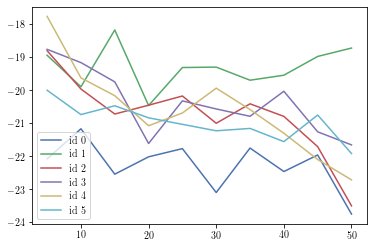

In [11]:
y = list(map(list, zip(*res_list_cov1)))

for i in range(6):
    plt.plot(x_cov1,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [12]:
res_list_cov2 = []
x_cov2 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov2):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=i,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=2.5,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov2.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    5.00 dB
Noise uncert:   10.00 dB
SNR:            -4.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:07<01:03,  7.06s/it]

---- Simulation stats ----
Err time:             -22.7947 dB
Err band:             -5.2342 dB
Err eigenval average: -5.9837 dB
Err eigenval hist:    -8.2502 dB
Err eigenval kde:     -4.6835 dB
Err eigenval mle:     -12.0629 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:15<00:58,  7.34s/it]

---- Simulation stats ----
Err time:             -22.0136 dB
Err band:             -8.3723 dB
Err eigenval average: -19.6584 dB
Err eigenval hist:    -17.9667 dB
Err eigenval kde:     -18.2832 dB
Err eigenval mle:     -18.6460 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    15.00 dB
Noise uncert:   10.00 dB
SNR:            -14.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:25<00:57,  8.25s/it]

---- Simulation stats ----
Err time:             -20.7041 dB
Err band:             -9.5267 dB
Err eigenval average: -18.3851 dB
Err eigenval hist:    -16.0785 dB
Err eigenval kde:     -18.3225 dB
Err eigenval mle:     -19.1335 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    20.00 dB
Noise uncert:   10.00 dB
SNR:            -19.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:37<00:56,  9.42s/it]

---- Simulation stats ----
Err time:             -21.7812 dB
Err band:             -12.7847 dB
Err eigenval average: -18.8229 dB
Err eigenval hist:    -17.4431 dB
Err eigenval kde:     -17.5692 dB
Err eigenval mle:     -19.0596 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    25.00 dB
Noise uncert:   10.00 dB
SNR:            -24.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [00:52<00:55, 11.18s/it]

---- Simulation stats ----
Err time:             -22.0167 dB
Err band:             -15.6122 dB
Err eigenval average: -18.0432 dB
Err eigenval hist:    -17.4744 dB
Err eigenval kde:     -17.8810 dB
Err eigenval mle:     -18.9893 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    30.00 dB
Noise uncert:   10.00 dB
SNR:            -29.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:11<00:53, 13.36s/it]

---- Simulation stats ----
Err time:             -22.4849 dB
Err band:             -17.9586 dB
Err eigenval average: -17.7004 dB
Err eigenval hist:    -17.4576 dB
Err eigenval kde:     -17.3553 dB
Err eigenval mle:     -18.7306 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    35.00 dB
Noise uncert:   10.00 dB
SNR:            -34.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:32<00:47, 15.67s/it]

---- Simulation stats ----
Err time:             -22.4075 dB
Err band:             -17.5744 dB
Err eigenval average: -19.7965 dB
Err eigenval hist:    -19.8205 dB
Err eigenval kde:     -19.2322 dB
Err eigenval mle:     -21.3035 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    40.00 dB
Noise uncert:   10.00 dB
SNR:            -39.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [01:56<00:36, 18.22s/it]

---- Simulation stats ----
Err time:             -22.0485 dB
Err band:             -17.9195 dB
Err eigenval average: -21.0911 dB
Err eigenval hist:    -19.1783 dB
Err eigenval kde:     -21.3625 dB
Err eigenval mle:     -20.5293 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    45.00 dB
Noise uncert:   10.00 dB
SNR:            -44.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [02:23<00:20, 20.76s/it]

---- Simulation stats ----
Err time:             -23.2022 dB
Err band:             -19.3617 dB
Err eigenval average: -22.8003 dB
Err eigenval hist:    -21.6830 dB
Err eigenval kde:     -22.2794 dB
Err eigenval mle:     -22.4447 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    50.00 dB
Noise uncert:   10.00 dB
SNR:            -49.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [02:51<00:00, 17.17s/it]

---- Simulation stats ----
Err time:             -22.6488 dB
Err band:             -19.0637 dB
Err eigenval average: -22.5258 dB
Err eigenval hist:    -20.9792 dB
Err eigenval kde:     -21.5810 dB
Err eigenval mle:     -20.7507 dB


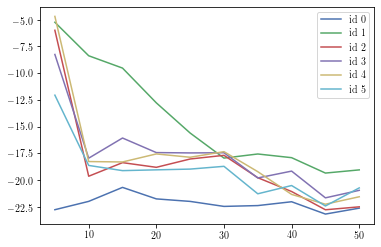

In [13]:
y = list(map(list, zip(*res_list_cov2)))

for i in range(6):
    plt.plot(x_cov2,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [14]:
res_list_cov3 = []
x_cov3 = [20, 40, 60, 80, 100]

for i in tqdm.tqdm(x_cov3):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=i,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=4,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov3.append(res)

  0%|          | 0/5 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    20.00 dB
Noise uncert:   10.00 dB
SNR:            -19.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 1/5 [00:11<00:45, 11.27s/it]

---- Simulation stats ----
Err time:             -21.0006 dB
Err band:             -7.4815 dB
Err eigenval average: -12.5666 dB
Err eigenval hist:    -12.7457 dB
Err eigenval kde:     -11.9963 dB
Err eigenval mle:     -13.5579 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    40.00 dB
Noise uncert:   10.00 dB
SNR:            -39.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 2/5 [00:36<00:46, 15.44s/it]

---- Simulation stats ----
Err time:             -21.9738 dB
Err band:             -18.5678 dB
Err eigenval average: -20.4740 dB
Err eigenval hist:    -18.1806 dB
Err eigenval kde:     -20.4188 dB
Err eigenval mle:     -20.6592 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    60.00 dB
Noise uncert:   10.00 dB
SNR:            -59.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 3/5 [01:09<00:41, 20.86s/it]

---- Simulation stats ----
Err time:             -22.0411 dB
Err band:             -19.7369 dB
Err eigenval average: -21.7801 dB
Err eigenval hist:    -21.1440 dB
Err eigenval kde:     -21.8937 dB
Err eigenval mle:     -19.5483 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    80.00 dB
Noise uncert:   10.00 dB
SNR:            -79.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 4/5 [01:54<00:28, 28.05s/it]

---- Simulation stats ----
Err time:             -22.7093 dB
Err band:             -19.6442 dB
Err eigenval average: -22.5159 dB
Err eigenval hist:    -22.9026 dB
Err eigenval kde:     -22.8365 dB
Err eigenval mle:     -20.1806 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    100.00 dB
Noise uncert:   10.00 dB
SNR:            -99.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 5/5 [02:51<00:00, 34.39s/it]

---- Simulation stats ----
Err time:             -24.9494 dB
Err band:             -19.4626 dB
Err eigenval average: -24.3141 dB
Err eigenval hist:    -21.0053 dB
Err eigenval kde:     -23.9243 dB
Err eigenval mle:     -19.7727 dB


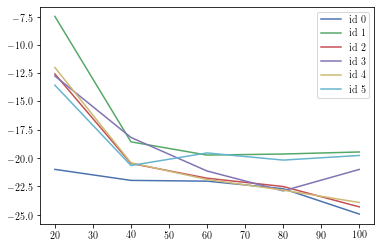

In [15]:
y = list(map(list, zip(*res_list_cov3)))

for i in range(6):
    plt.plot(x_cov3,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

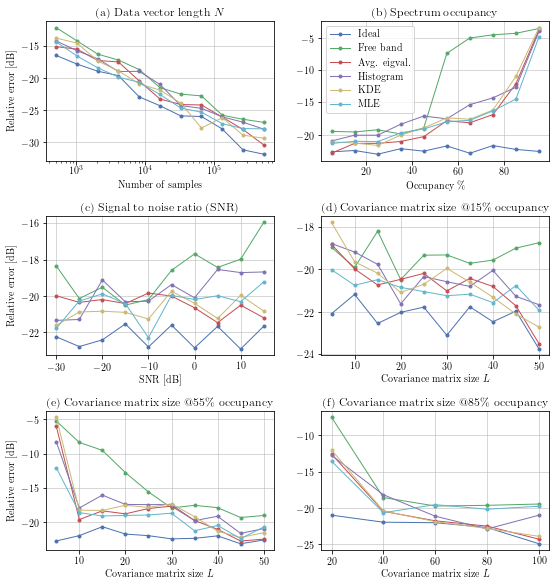

In [18]:
types = [r'Ideal', r'Free band', r'Avg. eigval.', r'Histogram', r'KDE', r'MLE']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8.25))

y = list(map(list, zip(*res_list_length)))
for i in range(6):
    axs[0, 0].plot(x_length, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 0].set_xlabel(r'Number of samples')
axs[0, 0].set_ylabel(r'Relative error [dB]')
axs[0, 0].set_title(r'(a) Data vector length $N$')
axs[0, 0].set_xscale('log')
axs[0, 0].grid(linewidth=0.5)

x_special = list(map(lambda x: round((x/5+0.05)*100, 2), x_sigs))
y = list(map(list, zip(*res_list_sigs)))
for i in range(6):
    axs[0, 1].plot(x_special, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 1].set_xlabel(r'Occupancy \%')
# axs[0, 1].set_ylabel(r'Relative error [dB]')
axs[0, 1].set_title(r'(b) Spectrum occupancy')
axs[0, 1].legend(loc=0)
axs[0, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_snr)))
for i in range(6):
    axs[1, 0].plot(x_snr, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 0].set_xlabel(r'SNR [dB]')
axs[1, 0].set_ylabel(r'Relative error [dB]')
axs[1, 0].set_title(r'(c) Signal to noise ratio (SNR)')
axs[1, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov1)))
for i in range(6):
    axs[1, 1].plot(x_cov1, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 1].set_xlabel(r'Covariance matrix size $L$')
# axs[1, 1].set_ylabel(r'Relative error [dB]')
axs[1, 1].set_title(r'(d) Covariance matrix size $@15\%$ occupancy')
axs[1, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov2)))
for i in range(6):
    axs[2, 0].plot(x_cov2, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 0].set_xlabel(r'Covariance matrix size $L$')
axs[2, 0].set_ylabel(r'Relative error [dB]')
axs[2, 0].set_title(r'(e) Covariance matrix size $@55\%$ occupancy')
axs[2, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov3)))
for i in range(6):
    axs[2, 1].plot(x_cov3, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 1].set_xlabel(r'Covariance matrix size $L$')
# axs[2, 1].set_ylabel(r'Relative error [dB]')
axs[2, 1].set_title(r'(f) Covariance matrix size $@85\%$ occupancy')
axs[2, 1].grid(linewidth=0.5)

plt.tight_layout()
plt.savefig('out/chap5/noise_estimation_comparison.pdf')